# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: Anna Knabe, Konrad Buchmann  
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
%matplotlib inline

import math
from typing import List
from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from tqdm.notebook import tqdm, trange
from multiprocessing import cpu_count

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [3]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [4]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.
data = train_dataset.data / 255
mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print("Mean:", mean, "Std:", std)

100%|██████████| 170498071/170498071 [00:07<00:00, 23388814.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Mean: [0.49139968 0.48215841 0.44653091] Std: [0.24703223 0.24348513 0.26158784]


In [5]:
validation_ratio = 0.1
val_size = int(validation_ratio * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
n_cores = cpu_count()
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=n_cores, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=n_cores, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=n_cores, pin_memory=True)

In [7]:
def un_normalize(data):
    inv_norm = transforms.Compose([
        transforms.Normalize((0., 0., 0.), (1/0.2470, 1/0.2435, 1/0.2616)),
        transforms.Normalize((-0.4914, -0.4822, -0.4465), (1., 1., 1.))
    ])
    
    return inv_norm(data)

In [8]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    ## TODO:
    grid_size = math.sqrt(batch_size)
    assert grid_size.is_integer()
    grid_size = int(grid_size)
    
    images, labels = next(iter(dl))
    images = un_normalize(images)
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize = (25,25), tight_layout=True)
    
    for ax, img, lbl in zip(axes.flat, images, labels):
        ax.set_axis_off()
        ax.set_title(train_dataset.dataset.classes[lbl])
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow((img * 255).astype(np.uint8))

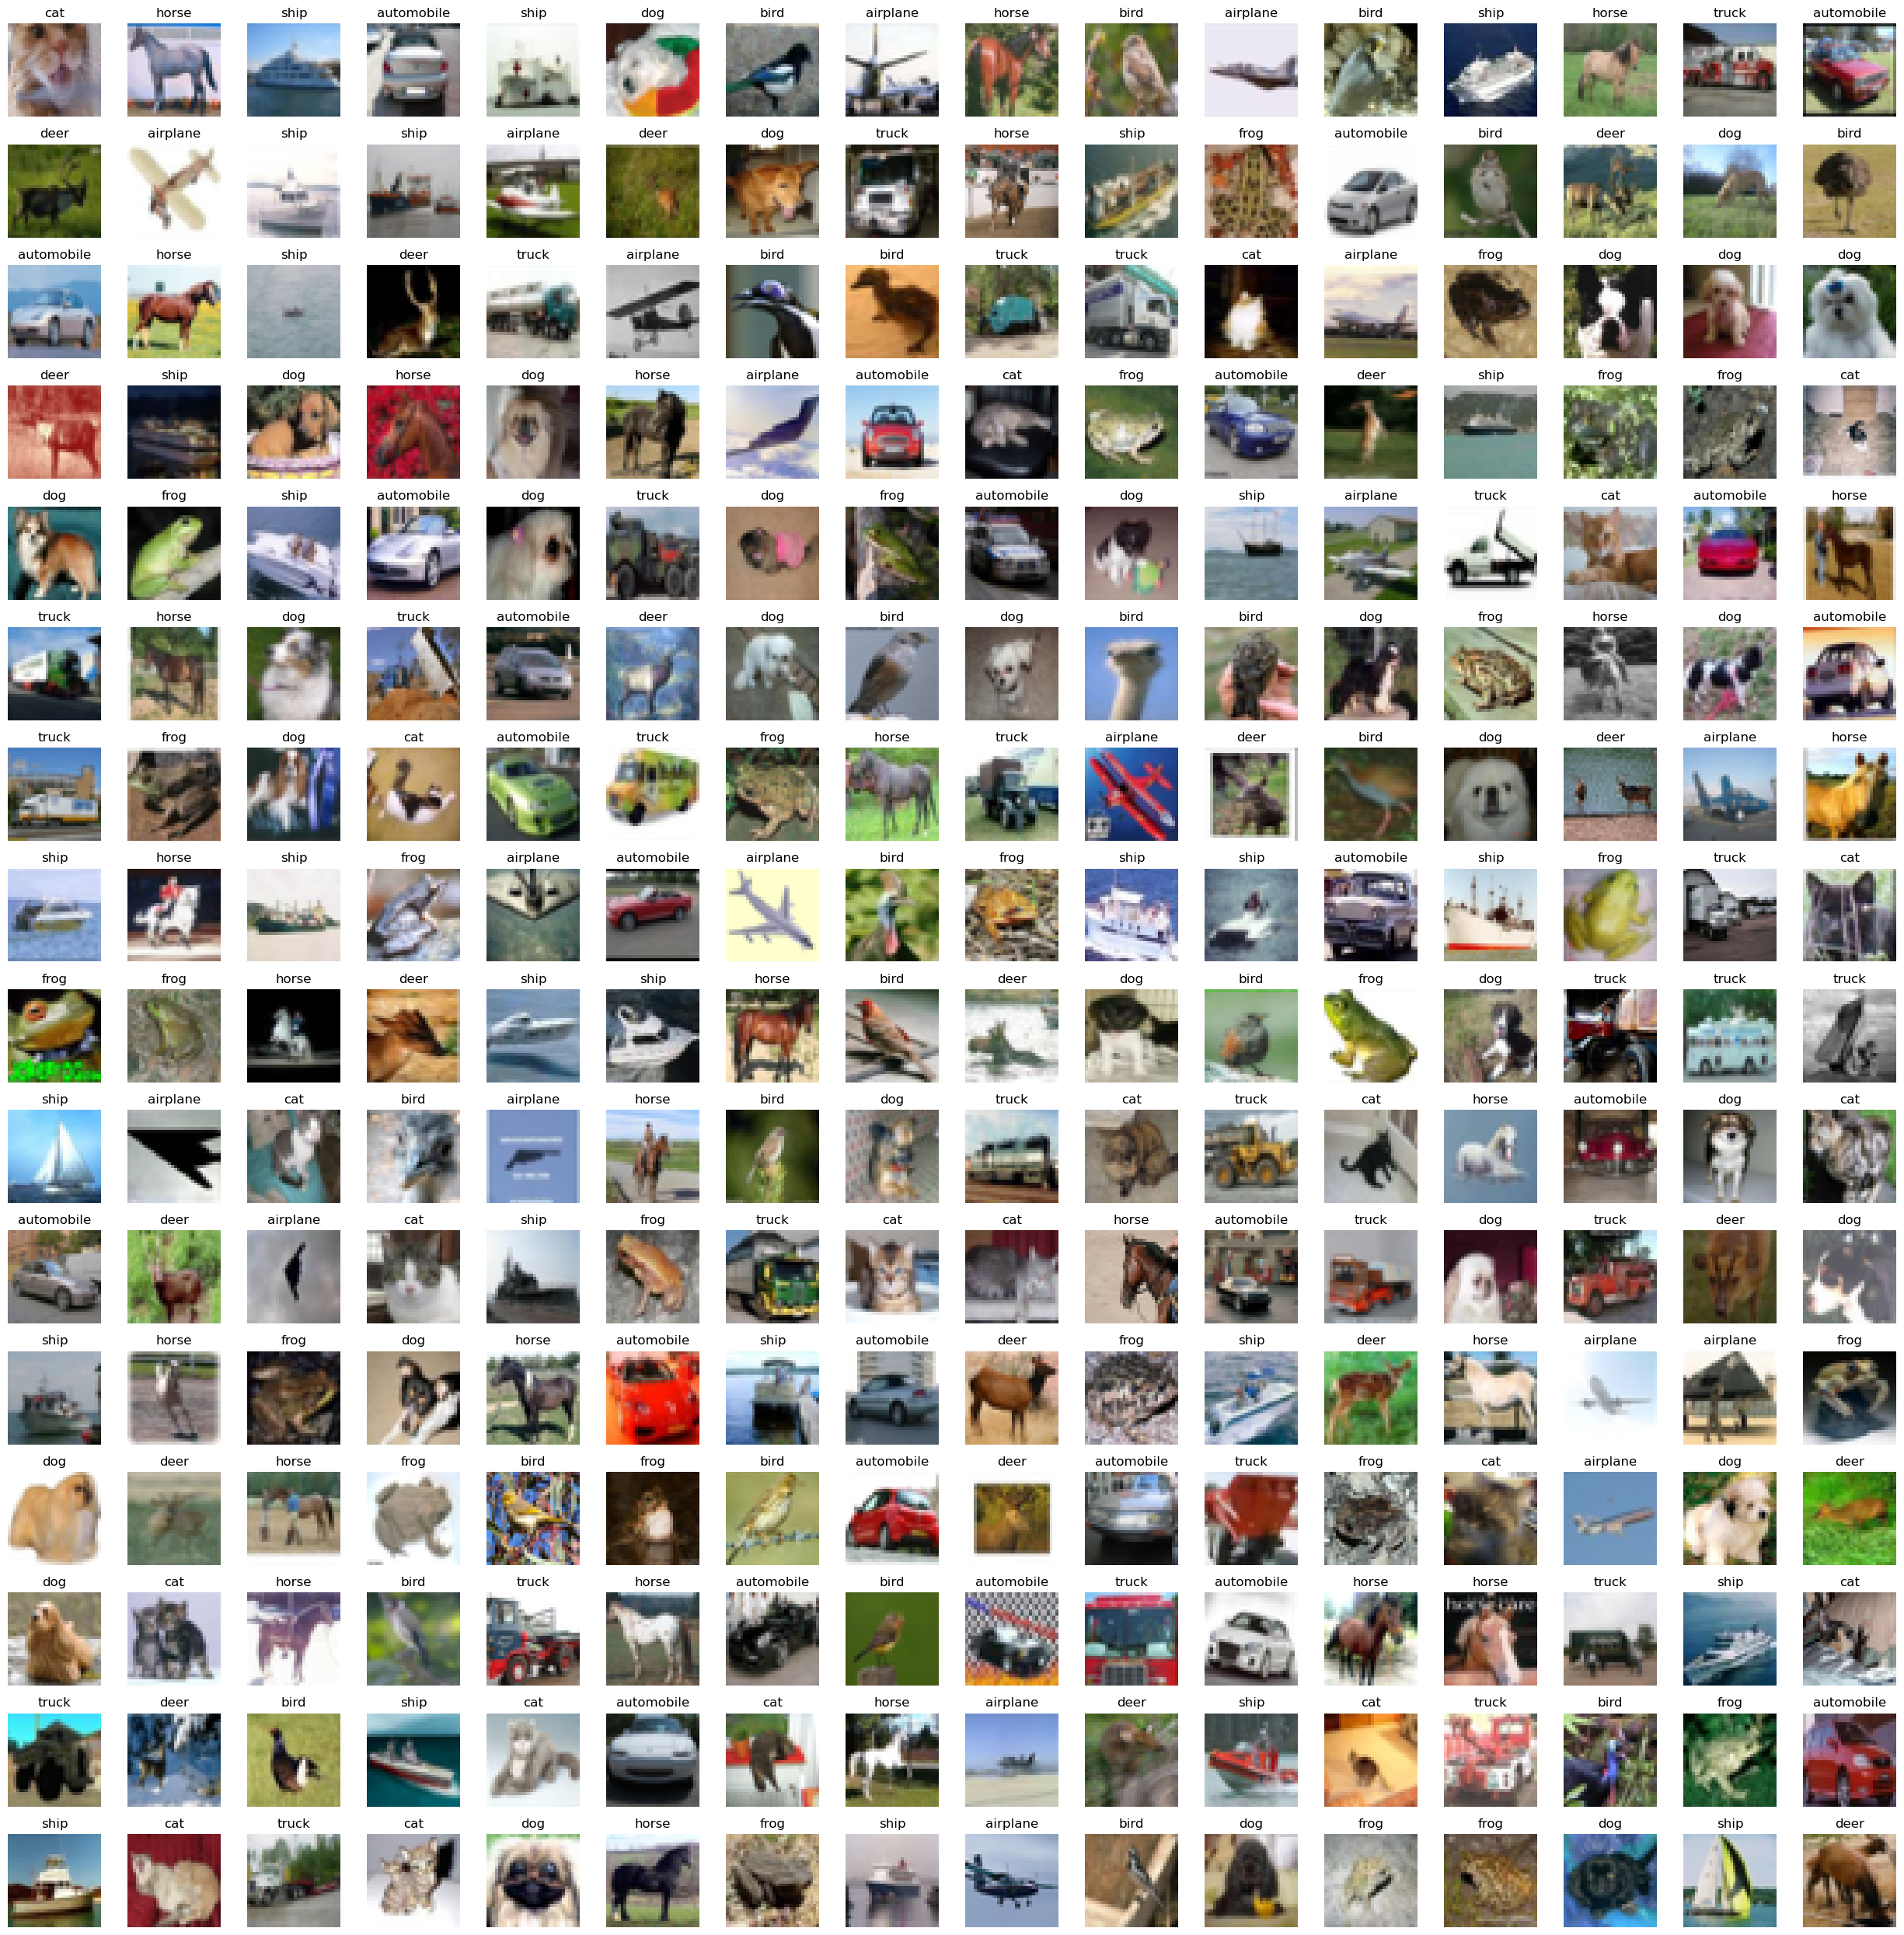

In [9]:
show_batch(train_loader)

In [10]:
num_classes = 10

x, y = next(iter(train_loader))

print("Batch shapes:")
print("x:", x.shape, "\ny:", y.shape)

Batch shapes:
x: torch.Size([256, 3, 32, 32]) 
y: torch.Size([256])


## Define helper functions for training and metrics

You will need these again and again. 

In [11]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total):
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = correct/total

    return ratio

In [12]:
@dataclass
class Performance:
    loss: float
    accuracy: float

class TrainingMetrics:
    def __init__(self):
        self.train = []
        self.val = []

@dataclass
class FinalPerformanceMetrics:
    performance: Performance
    confusion_matrix: np.ndarray

In [13]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 

def train_or_validate(dataloader, model, loss_fn, device, optimizer=None):
    """ 
    train or validate the model, depending on the presence of an optimizer:
        - optimizer means train
        - no optimizer means validate
    """
    is_training = optimizer is not None
    
    if is_training:
        model.train()
    else:
        model.eval()
    
    loss_per_batch = []
    accuracy_per_batch = []
    
    with torch.set_grad_enabled(is_training):
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
        
            if is_training:
                optimizer.zero_grad()
            
            y_pred = model(x)
            
            loss = loss_fn(y_pred, y)
            loss_per_batch.append(loss.item())
        
            predicted_classes = torch.argmax(y_pred, dim=1)
            n_correct_predictions = (predicted_classes == y).sum().item()
            accuracy = n_correct_predictions / batch_size
            accuracy_per_batch.append(accuracy)
        
            if is_training:
                loss.backward()
                optimizer.step()
    
    perf = Performance(loss = np.mean(loss_per_batch), 
                       accuracy = np.mean(accuracy_per_batch))
    
    return perf

In [14]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 

def run_training(model, 
                 optimizer, 
                 loss_function, 
                 device, 
                 num_epochs, 
                 train_dataloader, 
                 val_dataloader):
    """ method to run the training procedure """
    metrics = TrainingMetrics()
    
    with trange(num_epochs, unit="epoch", desc="Training") as progress_bar:
        for epoch in progress_bar:
            # Train one epoch
            perf = train_or_validate(train_dataloader, model, loss_function, device, optimizer=optimizer)
            metrics.train.append(perf)
            
            # Update progress bar
            progress_bar.set_postfix({"loss": perf.loss, "accuracy": perf.accuracy})
            
            # Validate
            perf = train_or_validate(val_dataloader, model, loss_function, device)
            metrics.val.append(perf)
    
    return metrics

In [15]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    model.eval()
    
    true_classes = []
    predicted_classes = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            y_pred = model(x)
            
            predicted_classes.extend(torch.argmax(y_pred, dim=1).tolist())
            true_classes.extend(y.tolist())
    
    confusion_matrix = sklearn.metrics.confusion_matrix(true_classes, predicted_classes, normalize="true")
    return confusion_matrix

In [16]:
def test_model(test_dataloader, model, loss_fn, device):
    perf = train_or_validate(test_loader, model, loss_fn, device)
    confusion_matrix = calc_confusion_values(test_dataloader, model, device)
    
    metrics = FinalPerformanceMetrics(performance = perf,
                                      confusion_matrix = confusion_matrix)
    
    return metrics

In [17]:
def plot_confusion_matrix(confusion_matrix):
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=test_dataset.classes)
    disp.plot()
    plt.show()

In [18]:
def plot_training_progress(train_loss, train_accuracy, val_loss, val_accuracy):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    loss_ax = axs[0]
    accy_ax = axs[1]

    loss_ax.set_title("Loss per Epoch")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.plot(train_loss, label="Training")
    loss_ax.plot(val_loss, label="Validation")
    loss_ax.legend()

    accy_ax.set_title("Accuracy per Epoch")
    accy_ax.set_xlabel("Epoch")
    accy_ax.set_ylabel("Accuracy")
    accy_ax.plot(train_accuracy, label="Training")
    accy_ax.plot(val_accuracy, label="Validation")
    accy_ax.legend()
    
    plt.show()

## Logistic Regression   

In [19]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        x = x.view(x.size(0), -1)
        
        # TODO: run the data through the layer
        outputs = self.linear(x)
        return outputs

In [20]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
linear_regression = LR(32*32*3, num_classes).to(device).train()

In [21]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [22]:
# TODO: define the loss function
loss_fn = nn.CrossEntropyLoss()

In [23]:
num_epochs = 20
## TODO: run training over 20 epochs
lr_training_metrics = run_training(linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)
lr_final_metrics = test_model(test_loader, linear_regression, loss_fn, device)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

*Because without them, any model reduces to linear regression.*

In [24]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity
        super().__init__()
        
        self.fc1 = torch.nn.Linear(input_dim, 1650)
        self.fc2 = torch.nn.Linear(1650, 512)
        self.fc3 = torch.nn.Linear(512, 138)
        self.fc4 = torch.nn.Linear(138, output_dim)
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input
        xb = xb.view(xb.size(0), -1)        
        xb = self.fc1(xb)
        xb = F.relu(xb)
        xb = self.fc2(xb)
        xb = F.relu(xb)
        xb = self.fc3(xb)
        xb = F.relu(xb)
        xb = self.fc4(xb)
        
        return xb

In [25]:
## TODO: Define network, put it to device and train mode
mlp = MLP(32*32*3, num_classes).to(device).train()

In [26]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [27]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20
mlp_training_metrics = run_training(mlp, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)
mlp_final_metrics = test_model(test_loader, mlp, loss_fn, device)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

## Add L2 regularisation

In [28]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
mlp = MLP(32*32*3, num_classes).to(device).train()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()

In [29]:
## TODO: Retrain new model with regularization over 20 epochs
num_epochs = 20
mlp_l2_training_metrics = run_training(mlp, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)
mlp_l2_final_metrics = test_model(test_loader, mlp, loss_fn, device)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

## LeNet5

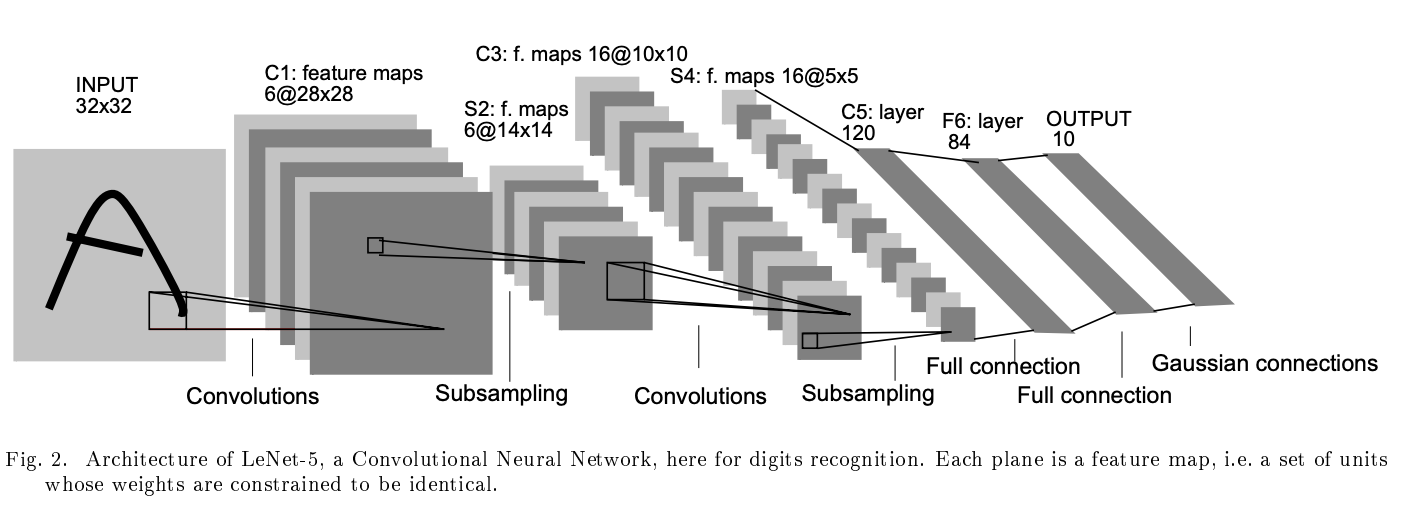

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [30]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [31]:
## TODO: define network, put it to the device and train mode
lenet5 = LeNet5(num_classes, in_channels=3).to(device).train()

In [32]:
## TODO: define loss function and optimisers
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [33]:
## TODO: train with 20 epochs
num_epochs = 20
lenet5_training_metrics = run_training(lenet5, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)
lenet5_final_metrics = test_model(test_loader, lenet5, loss_fn, device)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

## Analysis 

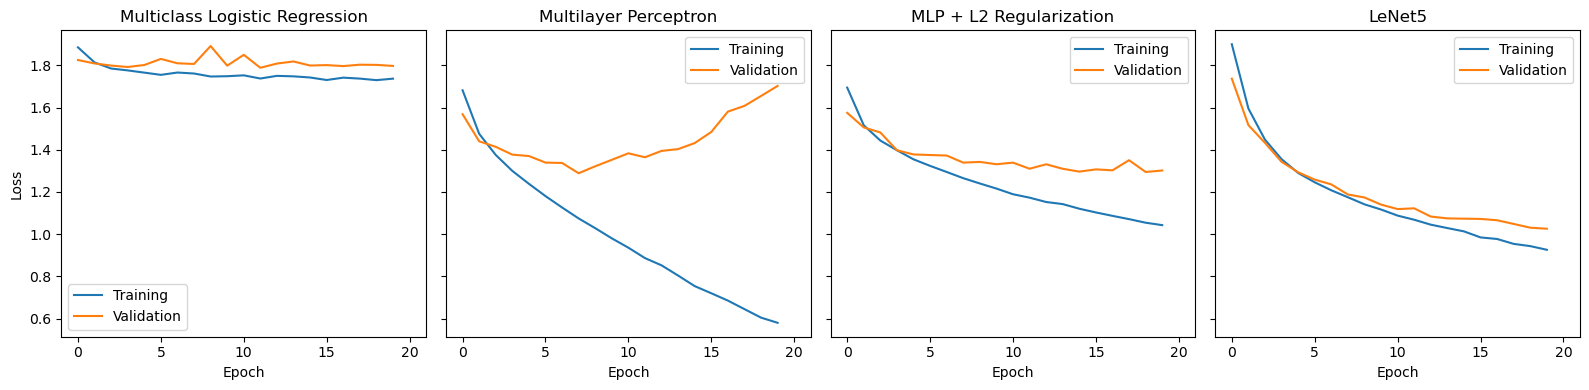

In [34]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), tight_layout=True)

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.set_xlim([-1,num_epochs+1])
    ax.set_xticks([0,5,10,15,20])

axs[0].set_ylabel("Loss")
axs[0].set_title("Multiclass Logistic Regression")
axs[0].plot([p.loss for p in lr_training_metrics.train], label="Training")
axs[0].plot([p.loss for p in lr_training_metrics.val], label="Validation")

axs[1].set_title("Multilayer Perceptron")
axs[1].plot([p.loss for p in mlp_training_metrics.train], label="Training")
axs[1].plot([p.loss for p in mlp_training_metrics.val], label="Validation")

axs[2].set_title("MLP + L2 Regularization")
axs[2].plot([p.loss for p in mlp_l2_training_metrics.train], label="Training")
axs[2].plot([p.loss for p in mlp_l2_training_metrics.val], label="Validation")

axs[3].set_title("LeNet5")
axs[3].plot([p.loss for p in lenet5_training_metrics.train], label="Training")
axs[3].plot([p.loss for p in lenet5_training_metrics.val], label="Validation")

for ax in axs:
    ax.legend()

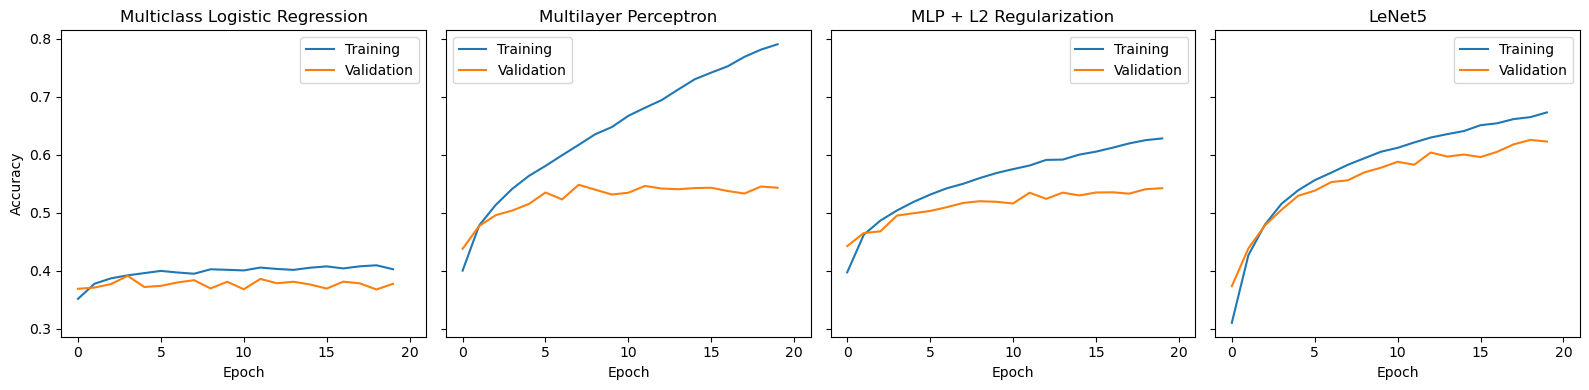

In [35]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?
fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), tight_layout=True)

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.set_xlim([-1,num_epochs+1])
    ax.set_xticks([0,5,10,15,20])

axs[0].set_ylabel("Accuracy")
axs[0].set_title("Multiclass Logistic Regression")
axs[0].plot([p.accuracy for p in lr_training_metrics.train], label="Training")
axs[0].plot([p.accuracy for p in lr_training_metrics.val], label="Validation")

axs[1].set_title("Multilayer Perceptron")
axs[1].plot([p.accuracy for p in mlp_training_metrics.train], label="Training")
axs[1].plot([p.accuracy for p in mlp_training_metrics.val], label="Validation")

axs[2].set_title("MLP + L2 Regularization")
axs[2].plot([p.accuracy for p in mlp_l2_training_metrics.train], label="Training")
axs[2].plot([p.accuracy for p in mlp_l2_training_metrics.val], label="Validation")

axs[3].set_title("LeNet5")
axs[3].plot([p.accuracy for p in lenet5_training_metrics.train], label="Training")
axs[3].plot([p.accuracy for p in lenet5_training_metrics.val], label="Validation")

for ax in axs:
    ax.legend()

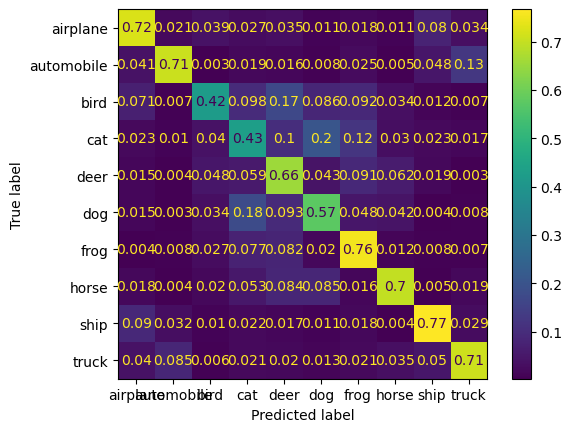

In [36]:
## TODO: Plot the confusion matrix for LeNet5
cm = calc_confusion_values(test_loader, lenet5, device)
plot_confusion_matrix(cm)

## Questions
#### How did regularization change the performance of the MLP? Why?

The MLP suffered from serious overfitting (as evident by falling training loss and rising validation loss), and L2 Regularization reduced that significantly by penalizing large model parameters. The final performance seems to be similar.

#### Explain the confusion matrix for LeNet5. What do you see there?
For each true class we see how much of it is predicted as what class. Ideally this would be the identity matrix.

#### Explain the difference in peformance between linear regression, MLP, and LeNet5.
Logistic regression is not able to learn the highly nonlinear relationships in the image data. That's why it performs the worst.
In contrast, the MLP can do exactly that, and performs better, but is bound by the inability to learn features independently from their location in the image. The spatial invariance ot the CNN can do that, and performs the best of all models we implemented.

#### Why are convolutions better suited for pictures? Which properties of images do they exploit?
They use the 2-dimensional ordering of the pixels, and don't just consider them independent variables. Also the spatial invariance of the convolution helps to learn patterns, meta-patterns and so on.

#### Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
